Suppose $x(t)$ is a stochastic signal whose ensemble average $\bar x(t)$ strictly increases over time, e.g. the center of a propagating wave, or the position of a car unable to reverse. In neuroscience it could be the location in a songbird song.

We write this as

$\dot x = f(x) + \eta$

where $f(x) \geq 0$ and $\eta$ is noise.

Because of this noise, different samples of $x(t)$ will diverge from one another over time, regardless of our choice of $f$.

Given a target sequence $\bar x(t)$ that is solution to $\tau \dot x = f(x)$, our goal is to construct a control signal $a(x)$ potentially distributed in space but modulated only by a time-varying scalar function $b(t)$ such that if

$\dot y = \dot x + a(x)b(t)$

then 

$$\left<\frac{1}{T} \int_0^T dt (y(t) - \bar x(t))\right>_\eta$$

averaged over noise instantiations, is minimized. We assume $y(0) = x(0) = 0$.

Moreover, for very long signals, the error between $y(t)$ and $\bar x(t)$ should be bounded:

$$\lim\limits_{T\rightarrow \infty} \left<\frac{1}{T} \int_0^T dt (y(t) - \bar x(t))\right>_\eta < C.$$

We first note that $a(x)b(t) = a(x)$ i.e. not a function of $t$ does not work, since this can then be absorbed into $f$, leaving us with the same fundamental problem. Nor does $a(x)b(t) = b(t)$ work, since this will not be able to cancel the fluctuations given by stochastic $\eta$. How could the product $a(x)b(t)$ overcome this?

To gain intuition we first consider constant $f(x) = d$, i.e $\dot x = d + \eta$ with $\eta$ Gaussian white noise. We plot $\bar x(t)$ below and a few instantiations of $x(t)$ and their differences to $\bar x(t)$.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import types


import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size, fast_fig


dt = 1.
T = 1000
noise_std = 5
d = 1.

t = np.arange(0, T, dt)

x_bar = d*t

def run(seed=None, a=None, b=None):
    """
    Sample y(t).
    
    seed: int
    a: scalar func takes x as input
    b: 1-d array same size as t
    """
    if a is None:
        a = lambda x: 0
    if b is None:
        b = np.zeros(len(t))
        
    y = np.nan*np.zeros(len(t))
    y[0] = np.random.randn()*noise_std*dt
    
    np.random.seed(seed)
    
    for t_ctr, (t_, b_) in enumerate(zip(t[1:], b[1:]), 1):
        x = y[t_ctr-1]
        dx_dt = d + np.random.randn()*noise_std
        dy_dt = dx_dt + a(x)*b_
        dy = dy_dt*dt
        y[t_ctr] = y[t_ctr-1] + dy
        
    return y


def plot_ys(ys):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4), tight_layout=True)
    axs[0].plot(t, x_bar, c='k', lw=2)
    axs[0].plot(t, np.transpose(ys), lw=1)
    axs[1].plot(t, (np.array(ys) - x_bar).T)

    axs[0].set_title(r'$\bar x, y(t)$')
    axs[0].set_ylabel(r'$y$')
    axs[1].set_title(r'$y(t) - \bar x$')
    axs[1].set_ylabel(r'$y(t) - \bar x$')

    for ax in axs:
        ax.set_xlabel('Timestep')
        set_font_size(ax, 16)
        
        
def copy_func(f, name=None):
    '''
    return a function with same code, globals, defaults, closure, and 
    name (or provide a new name)
    '''
    fn = types.FunctionType(f.__code__, f.__globals__, name or f.__name__,
        f.__defaults__, f.__closure__)
    # in case f was given attrs (note this dict is a shallow copy):
    fn.__dict__.update(f.__dict__) 
    return fn

13961.04447532206


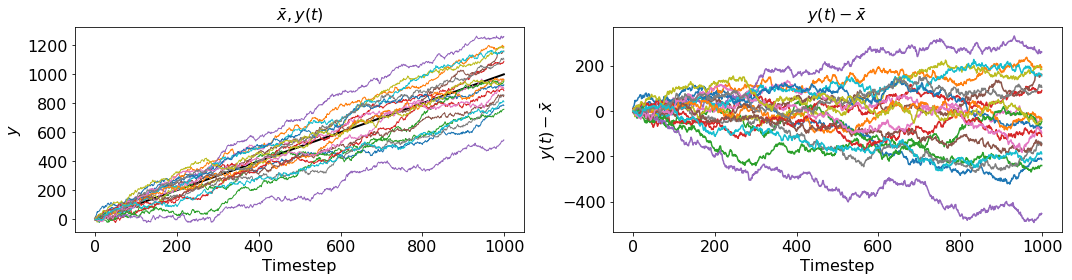

In [210]:
n_trl = 20

xs = [run(seed=tr_ctr, a=None, b=None) for tr_ctr in range(n_trl)]

plot_ys(xs)

print(np.mean([np.median((y - x_bar)**2) for y in xs]))

As expected $x(t)$ clearly diverges from $\bar x$ and other $x(t)$ over time.

How can we correct this with a proper choice of $c(x, t) = a(x)b(t)$? We have seen that if this is possible it must require both $a(x)$ and $b(t)$ to not be constant.

### Example solutions

Suppose $b(t) = \delta(t - T/2)$. The optimal a(x) resets x from wherever it is at $T/2$ to $\bar x(T/2)$ 

3166.267816298359


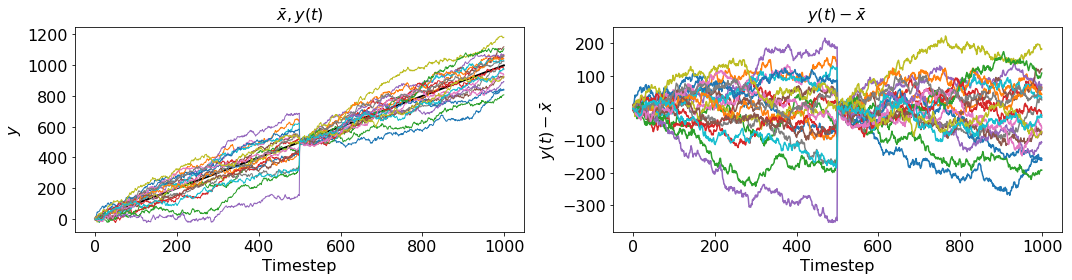

In [211]:
b = np.zeros(len(t))
t_idx = int(round(T/2/dt))
b[t_idx] = 1/dt
a = lambda x: x_bar[t_idx] - x

n_trl = 20

ys = [run(seed=tr_ctr, a=a, b=b) for tr_ctr in range(n_trl)]

plot_ys(ys)

print(np.mean([np.median((y - x_bar)**2) for y in ys]))

Suppose $b(t) = \delta(t - T/4) + \delta(t - 3T/4)$. We'll compare two different $a(x)$. First, $a(x)$ = $.5(\bar x(T/4) - x) + .5(\bar x(3T/4) - x)$.

56590.87445645806


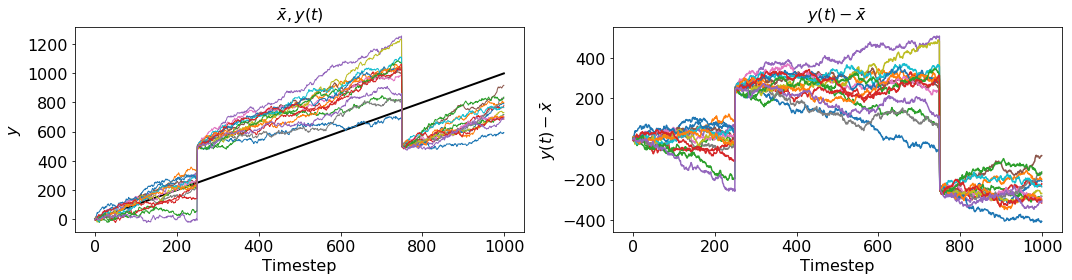

In [212]:
b = np.zeros(len(t))
t_idx_0 = int(round(T/4/dt))
b[t_idx_0] = 1/dt
t_idx_1 = int(round(3*T/4/dt))
b[t_idx_1] = 1/dt

a = lambda x: .5*(x_bar[t_idx_0] - x) + .5*(x_bar[t_idx_1] - x)

n_trl = 15

ys = [run(seed=tr_ctr, a=a, b=b) for tr_ctr in range(n_trl)]

plot_ys(ys)

print(np.mean([np.median((y - x_bar)**2) for y in ys]))

Second, $a(x) = \bar x (T/4) - x$ when $x < \bar x(T/2)$ and $a(x) = \bar x(3T/4) - x$ when $x \geq \bar x(T/2)$.

2852.495050243745


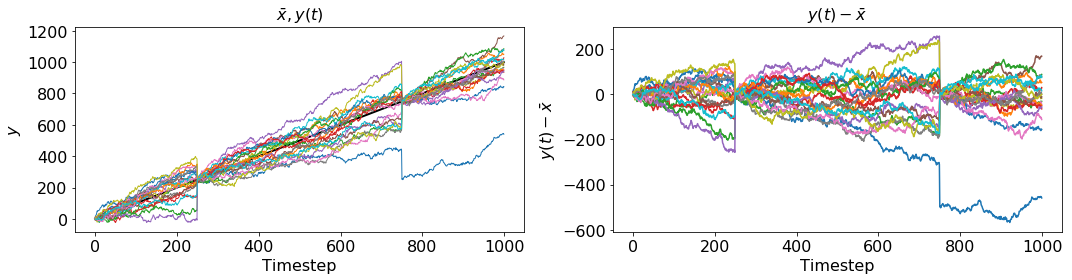

In [213]:
x_mid = x_bar[int(round(T/2/dt))]
a = lambda x: (x_bar[t_idx_0] - x) if x < x_mid else (x_bar[t_idx_1] - x)

n_trl = 20

ys = [run(seed=tr_ctr, a=a, b=b) for tr_ctr in range(n_trl)]

plot_ys(ys)

print(np.mean([np.median((y - x_bar)**2) for y in ys]))

2461.591551034696


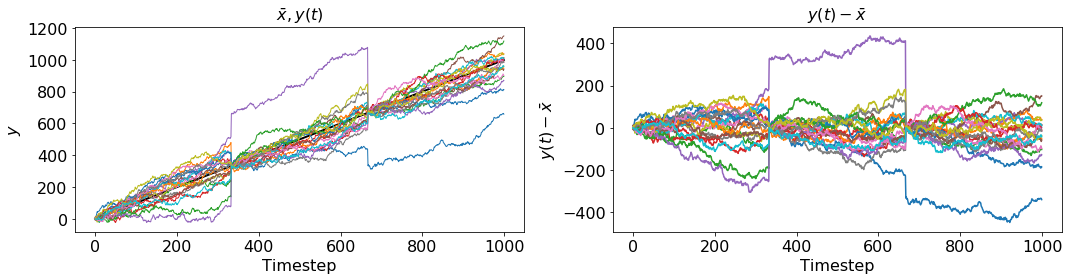

In [214]:
b = np.zeros(len(t))
t_idx_0 = int(round(T/3/dt))
b[t_idx_0] = 1/dt
t_idx_1 = int(round(2*T/3/dt))
b[t_idx_1] = 1/dt

x_mid = x_bar[int(round(T/2/dt))]
a = lambda x: (x_bar[t_idx_0] - x) if x < x_mid else (x_bar[t_idx_1] - x)

n_trl = 20

ys = [run(seed=tr_ctr, a=a, b=b) for tr_ctr in range(n_trl)]

plot_ys(ys)

print(np.mean([np.median((y - x_bar)**2) for y in ys]))

Thus, we see for most trials, a nonlinear combination of the solutions for individual $b(t) = \delta(t-T^*)$ reduces error more than a linear combination.

10556.661967548036


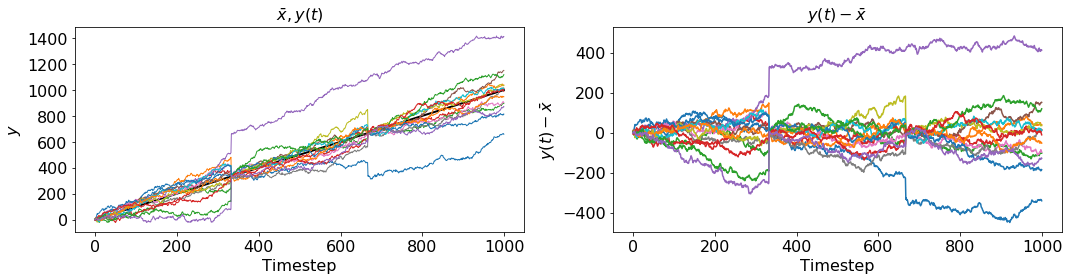

In [215]:
b = np.zeros(len(t))
t_idxs = []
t_stars = np.linspace(0, T, 4)[1:-1]
d_t_star = np.mean(np.diff(t_stars))

for t_star in t_stars:
    t_idx = int(round(t_star/dt))
    b[t_idx] = 1/dt
    t_idxs.append(t_idx)

def a(x):
    for t_idx, t_star in zip(t_idxs, t_stars):
        if t_idx == t_idxs[0]:
            t_idx_lb = 0
        else:
            t_idx_lb = int(np.round((t_star - d_t_star/2)/dt))
        
        if t_idx == t_idxs[-1]:
            t_idx_ub = len(x_bar) - 1
        else:
            t_idx_ub = int(np.round((t_star + d_t_star/2)/dt))

        if x_bar[t_idx_lb] <= x < x_bar[t_idx_ub]:
            
            return x_bar[t_idx] - x
    
    return 0

n_trl = 15

ys = [run(seed=tr_ctr, a=a, b=b) for tr_ctr in range(n_trl)]

plot_ys(ys)

print(np.mean([np.median((y - x_bar)**2) for y in ys]))

For a general $b(t)$, what is the best way to perform such nonlinear combination? Given $b(t)$ let us find $a(x)$ numerically. We proceed by choosing an initial $a(x)$, simulating several trajectories, then using their resulting variance to update $a(x)$, and iterating.

Specifically, for $a^*(x, t^*) = (1/dt)(\bar x(t^*) - x)$, we wish to find $a(x) = c_1(x)a^*(x, t_1^*) + c_2(x)a^*(x, t_2^*) + ...$, i.e. a weighted combination of the different $a^*(x, t^*)$ but where the weights are themselves $x$-dependent. Letting $\mathbf{c}(x) = (c_1(x), c_2(x), ...)$.

We use the following update scheme for $a(x)$ given trajectories $\{x(t)\}$ sampled using the previous $a(x)$. For every $t$ where $b(t) \neq 0$, calculate the mean $\mu(x(t))$ and variance $\sigma^2(x(t))$ and fit a squared exponential with max 1, $g_t(x) = n(\mu, \sigma^2)$. If there are $n_t$ nonzero entries in $b(t)$, this gives us $n_t$ functions $g_t(x)$. We will normalize these to sum to 1 at each $x$ (weighted by b(t)), then use them as our $\mathbf{c}(x)$.

In [106]:
def solve_a(b, a_0=lambda x: 0, n_trl=30, n_iter=10):

    ys_all = []
    
    sq_exp_all = []
    w_all = []
    a_all = []
    
    mu_all = []
    sgm_all = []
    
    a = a_0
    
    for i in range(n_iter):
        # sample ys
        ys = np.transpose([run(seed=tr_ctr, a=a, b=b) for tr_ctr in range(n_trl)])
        
        # store results
        ys_all.append(ys.copy())
        
        # update a using means and vars
        mu = ys.mean(axis=1)
        sgm = ys.std(axis=1, ddof=1)
        
        mu_all.append(mu)
        sgm_all.append(sgm)
        
        def w(x):
            # get weights at this x
            log_sq_exp = -.5*(x_bar - x)**2/((sgm/2)**2)
            log_w = log_sq_exp + np.log(b)
            log_w -= log_w.max()
            return np.exp(log_w), np.exp(log_sq_exp)  # one w per timepoint i.e. b(t)
            
        def a(x):  
            # use weights to calc a(x)
            w_ = w(x)[0]
            w_ / w_.sum()  # normalize weights
            return (np.dot(w_, x_bar) - x)/dt
        
        # store w & a as func of x
        x_test = np.arange(0, T, dt)
        sq_exp_all.append(np.transpose([w(x_)[1] for x_ in x_test]))
        w_all.append(np.transpose([w(x_)[0] for x_ in x_test]))
        a_all.append(np.array([a(x_) for x_ in x_test]))
        
    return ys_all, sq_exp_all, w_all, a_all, mu_all, sgm_all

Test numerical solver.

In [107]:
b = np.zeros(len(t))
t_idx_0 = int(round(T/4/dt))
b[t_idx_0] = 1
t_idx_1 = int(round(T/2/dt))
b[t_idx_1] = 1
t_idx_2 = int(round(3*T/4/dt))
b[t_idx_2] = 1

ys_all, sq_exp_all, w_all, a_all, mu_all, sgm_all = solve_a(b, n_trl=25, n_iter=10)

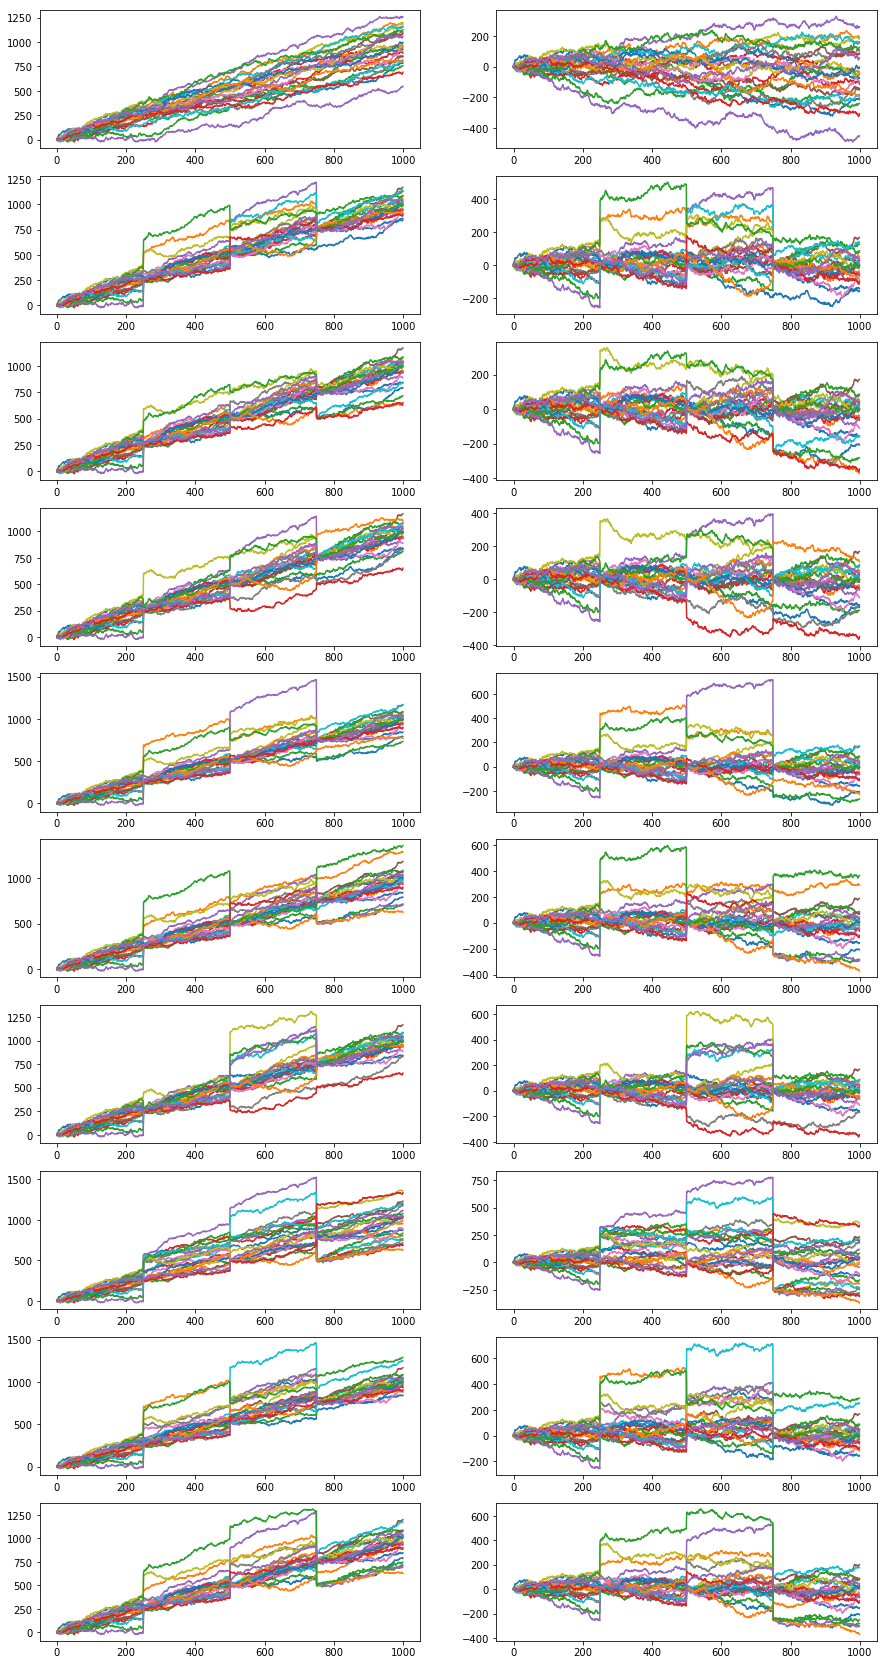

In [108]:
fig, axs = plt.subplots(10, 2, figsize=(15, 30))
for ys, ax_row in zip(ys_all, axs):
    ax_row[0].plot(t, ys)
    ax_row[1].plot(t, (ys.T - x_bar).T)

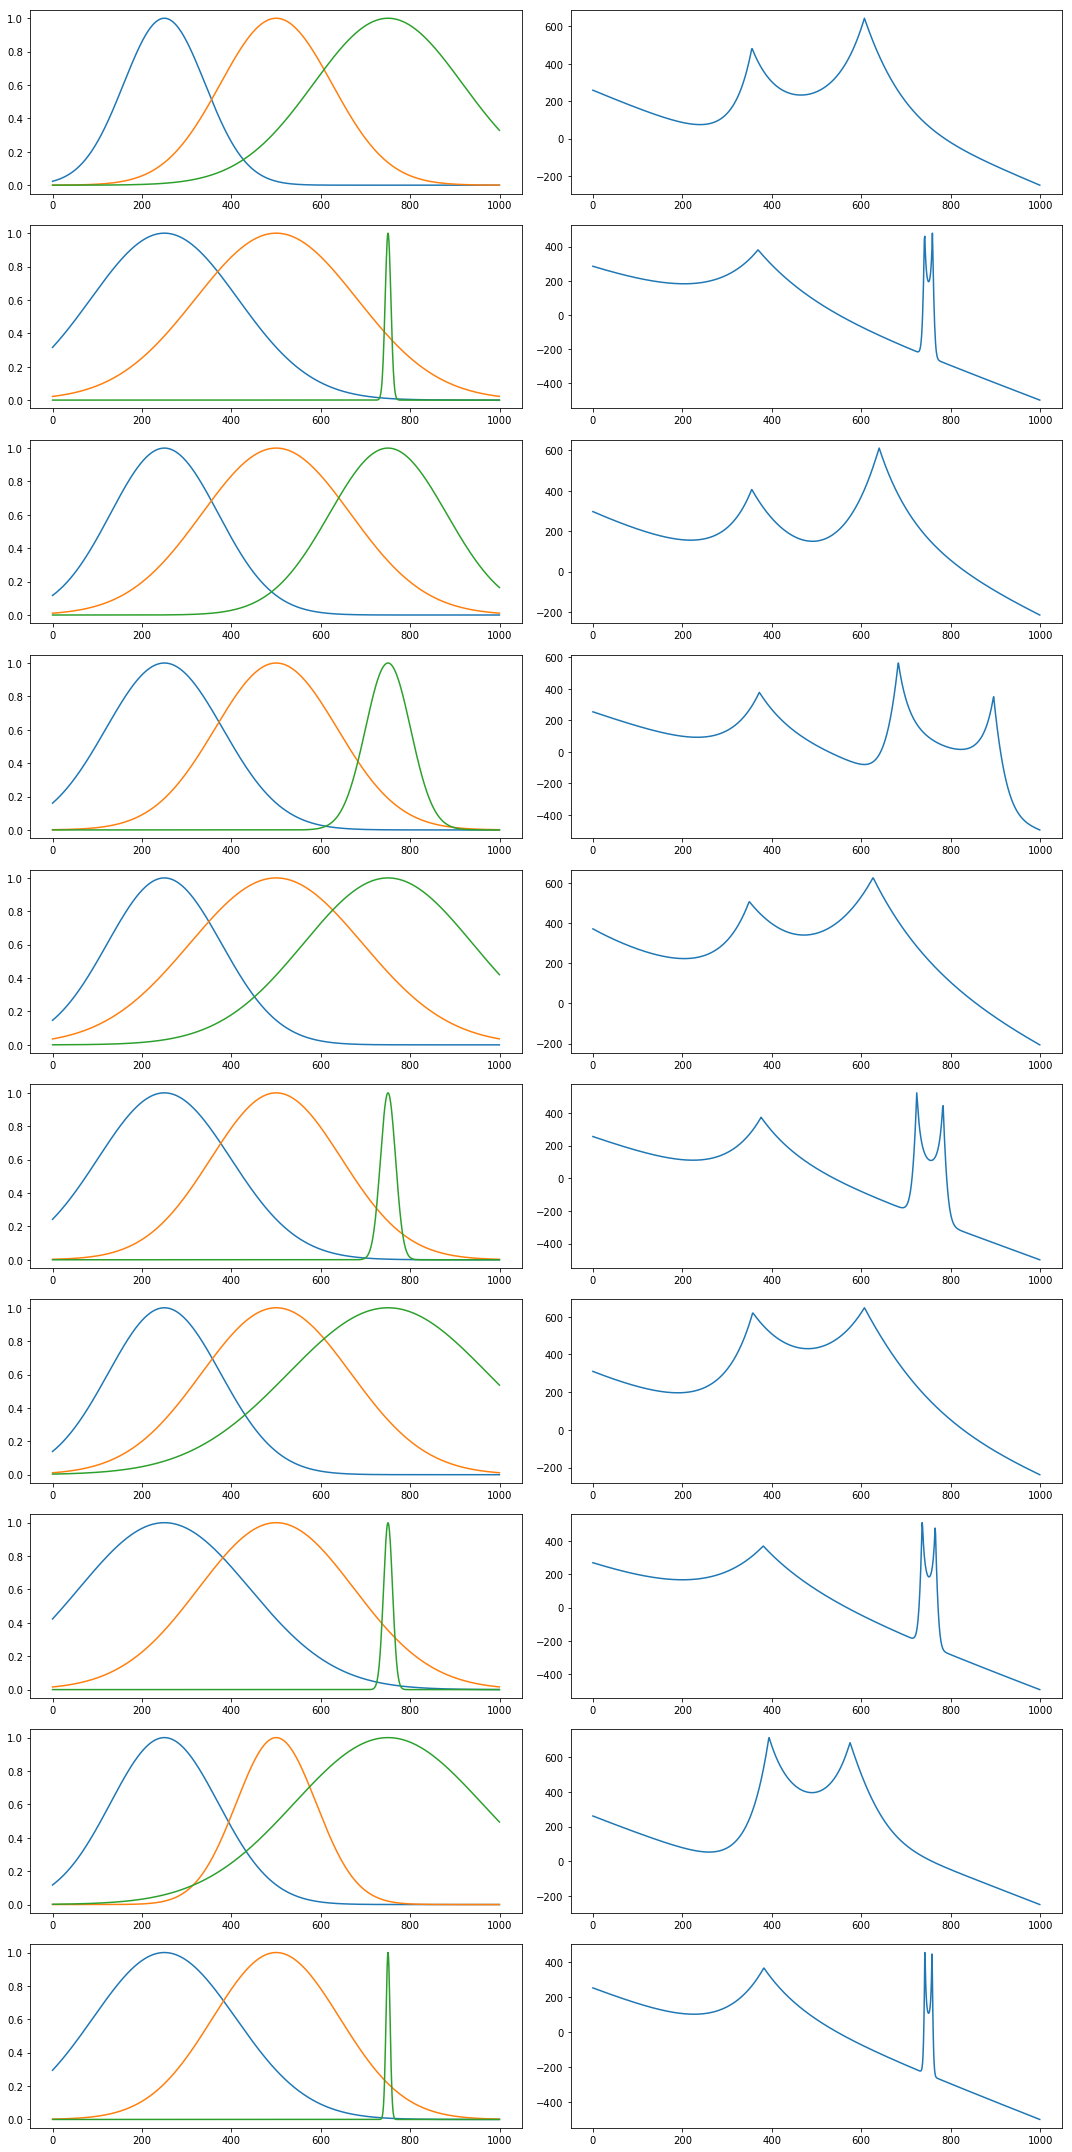

In [105]:
fig, axs = plt.subplots(10, 2, figsize=(15, 30), tight_layout=True)

for ax_row, sq_exp, a in zip(axs, sq_exp_all, a_all):
    # plot w
    for b_, sq_exp_row in zip(b, sq_exp):
        if b_ > 0:
            ax_row[0].plot(sq_exp_row)
    ax_row[1].plot(a)

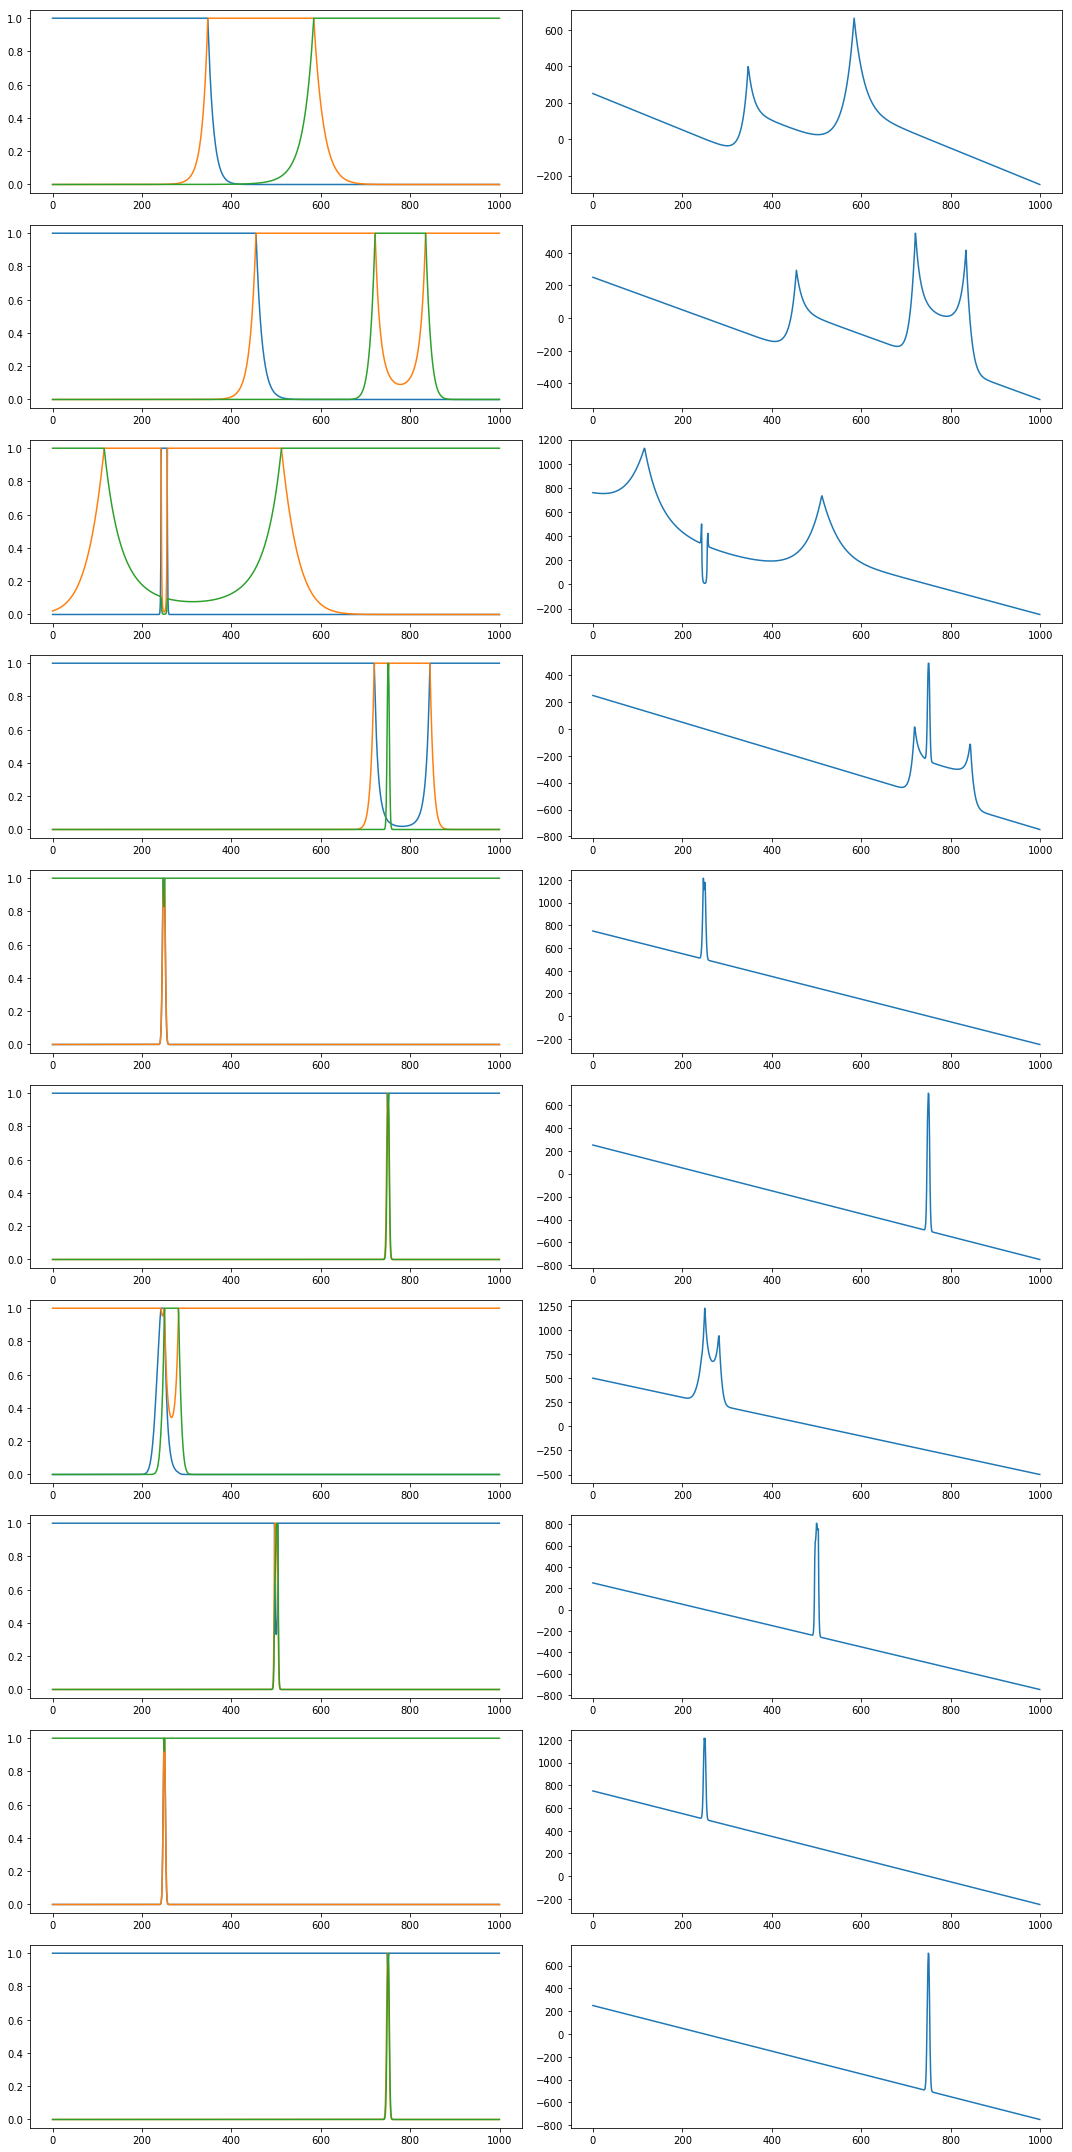

In [101]:
fig, axs = plt.subplots(10, 2, figsize=(15, 30), tight_layout=True)

for ax_row, w, a in zip(axs, w_all, a_all):
    # plot w
    for b_, w_row in zip(b, w):
        if b_ > 0:
            ax_row[0].plot(w_row)
    ax_row[1].plot(a)